__Нейросетевая языковая модель__

Евгений Борисов <esborisov@sevsu.ru>

charCNN-LSTM

генерирует следующий символ по предыдущим

In [1]:
import gzip
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm import tqdm
from os.path import join as pjoin

In [2]:
# from utils.helpers import ppr
# from utils.helpers import replace_patterns

In [3]:
def ppr(df): return print(len(df))

def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

In [4]:
np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth=200 

tqdm.pandas()

In [5]:
FOLDER_RESULT='result'

In [6]:
!mkdir result

mkdir: невозможно создать каталог «result»: Файл существует


## загружаем данные

In [8]:
FILE_DATA = '../data/dostoevsky-besy-p2.txt.gz'
with gzip.open(FILE_DATA,'rt',encoding='utf-8') as f: text = f.read()     
ppr(text)    

465595


In [9]:
print(text[:200]+'...')

БЕСЫ

Федор Михайлович Достоевский





ЧАСТЬ ВТОРАЯ



ГЛАВА ПЕРВАЯ



Ночь



I



Прошло восемь дней. Теперь, когда уже все прошло, и я пишу хронику, мы уже знаем в чем дело; но тогда мы еще ничего...


In [10]:
pat = [
    [r'([\.!\?;]+)',r'\1\n'],
    ['\n+','\n'],
]

data = pd.DataFrame({'line':replace_patterns(text,pat).split('\n')})
data.head(30)

,line
0,БЕСЫ
1,Федор Михайлович Достоевский
2,ЧАСТЬ ВТОРАЯ
3,ГЛАВА ПЕРВАЯ
4,Ночь
5,I
6,Прошло восемь дней.
7,"Теперь, когда уже все прошло, и я пишу хронику, мы уже знаем в чем дело;"
8,"но тогда мы еще ничего не знали, и естественно, что нам представлялись странными разные вещи."
9,По крайней мере мы со Степаном Трофимовичем в первое время заперлись и с испугом наблюдали издали.


In [11]:
data = data.iloc[6:]

In [12]:
data['line'] = data['line'].str.strip()
data['line'].str.len().describe().astype(int)

count    6828
mean       66
std        59
min         0
25%        26
50%        49
75%        89
max       584
Name: line, dtype: int64

In [13]:
ppr(data)
data = data[ data['line'].str.len()>0 ] 
ppr(data)

6828
6827


In [14]:
# data[data['line'].str.len()<1]

## очистка данных

In [15]:
def tokenize(s): 
    return [ w.strip() for w in re.split(r'\b| ',s) if w.strip() ]

In [16]:
pat = [
    [r'"|\'',' '],
    [r'\(|\)',','],
    ['\d+','D'],
    ['[a-z•^]+',' '],
    ['\n',' '],
    [',',' , '],
    ['-',' - '],
    [r' +',' ',],
]

data['line'] = data['line']\
    .progress_apply(lambda s: replace_patterns(s.lower(),pat).strip() )\
    .progress_apply(tokenize) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6827/6827 [00:00<00:00, 82072.48it/s]


In [17]:
%xdel text

In [18]:
ppr(data)
data.sample(4)

6827


,line
5799,"[необходимо, лишь, необходимое, ,, вот, девиз, земного, шара, отселе, .]"
593,"[-, по, чрезвычайному, дождю, грязь, по, здешним, улицам, нестерпимая, ,, -, доложил, алексей, егорович, в, виде, отдаленной, попытки, в, последний, раз, отклонить, барина, от, путешествия, .]"
4889,"[-, громко, захохотал, ставрогин, ;]"
2943,"[но, тут, подвернулся, петр, степанович, и, стало, происходить, нечто, странное, .]"


In [19]:
ppr(data)
data = data[ data['line'].str.len()>0 ] 
ppr(data)

6827
6791


In [20]:
# data[data['line'].str.len()<1]

## формируем словари

In [21]:
words = sorted(set(sum(data['line'].values.tolist(),[]) )) # список слов
ppr(words)
# words

15171


In [22]:
vocabulary = { a:i+1 for i,a in enumerate(words) } # словарь
vocabulary['PAD']=0
ppr(vocabulary)
# vocabulary

15172


In [23]:
# ord?

# [ chr(i) for i in range(0,100) ] 
# [ [i,chr(i)] for i in range(100,200) ] 
# [ [i,chr(i)] for i in range(200,300) ] 
# [ [i,chr(i)] for i in range(300,400) ] 
# [ [i,chr(i)] for i in range(500,600) ] 
# [ [i,chr(i)] for i in range(600,700) ] 
# [ [i,chr(i)] for i in range(700,800) ] 

In [24]:
abc = set(' '.join(words) ) # алфавит
abc = { a:i+1 for i,a in enumerate(sorted(abc)) }
zero_symbol = '\t'
abc[zero_symbol] = 0
ppr(abc)
# abc

42


In [25]:
# %xdel words

In [26]:
# voc_len = len(vocabulary)
# abc_len = len(abc)
# voc_len, len(words), abc_len, max(vocabulary.values()), max(abc.values())

----

In [27]:
words = pd.DataFrame({'word':words}) # список слов
max_word_len = words['word'].str.len().max() # максимальная длина слова
ppr(words)
# words.sample(3)
max_word_len

15171


19

In [28]:
# дополняем слово до максимальной длины
def pad_word(w,max_word_len=max_word_len,zero_symbol=zero_symbol):
    return w+zero_symbol*(max_word_len-len(w))

# заменяем символы слова на последовательность номеров символов в алфавите 
def encode_abc(w,abc=abc ): 
    return list(map(abc.get,w))

# выполняем OHE номеров символов 
def encode_abc_bin(codes,abc_len=len(abc)):
    return np.array([ np.eye(abc_len,dtype=int)[c] for c in codes ], dtype=int)[np.newaxis,:]


In [29]:
# w = 'символы'
# encode_abc_bin(encode_abc( pad_word(w) )).shape
# w+zero_symbol*(max_word_len-len(w))

In [30]:
words['code_char_bin_pad'] = words['word']\
                 .progress_apply(pad_word)\
                 .progress_apply(encode_abc)\
                 .progress_apply(encode_abc_bin)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15171/15171 [00:00<00:00, 19894.69it/s]


In [31]:
np.vstack(words['code_char_bin_pad']).shape

(15171, 19, 42)

In [32]:
# алфавит
ppr(abc)
# abc

42


In [33]:
# словарь
ppr(vocabulary)
# abc

15172


In [34]:
# таблица кодов слов
ppr(words)
words.sample(3)

15171


,word,code_char_bin_pad
5990,нами,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
14257,учреждений,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
8379,поводу,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## кодируем текст

In [35]:
# заменяем слова на последовательность номеров слов в словаре 
data['seq_code_word'] = data['line'].progress_apply(lambda s: [ vocabulary[w] for w in s ])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6791/6791 [00:00<00:00, 163593.08it/s]


In [36]:
# data['seq_code_word'].str.len().plot.hist()
data['seq_code_word'].str.len().describe([.1,.25,.5,.75,.9,.95,.99]).astype(int)

count    6791
mean       13
std        11
min         1
10%         4
25%         6
50%        10
75%        18
90%        28
95%        35
99%        54
max       111
Name: seq_code_word, dtype: int64

In [37]:
# последовательность слов (основной текст)
ppr(data)
data.sample(3)

6791


,line,seq_code_word
3823,"[лембке, покраснел, и, замялся, .]","[5094, 8841, 3985, 3594, 8]"
1694,"[-, но, ...]","[7, 6756, 10]"
3092,"[ей, вероятно, нравилось, ,, что, та, в, свою, очередь, почти, принижается, пред, николаем, всеволодовичем, и, любезничает, с, ним, как, ни, с, кем, .]","[3078, 913, 6819, 6, 14808, 13135, 766, 11568, 7927, 9451, 9994, 9547, 6721, 1507, 3985, 5254, 11378, 6728, 4426, 6682, 11378, 4534, 8]"


## собираем датасет

In [38]:
hist_deep = 5 # глубина истории контекста

In [39]:
data['seq_code_word'].str.len().describe([.1,.25,.5,.75,.9,.95,.99]).astype(int)

count    6791
mean       13
std        11
min         1
10%         4
25%         6
50%        10
75%        18
90%        28
95%        35
99%        54
max       111
Name: seq_code_word, dtype: int64

In [40]:
ppr(data)
# data = data[ data['seq_code_word'].str.len()>hist_deep ] 
data = data[ data['seq_code_word'].str.len().between(hist_deep+1,data['seq_code_word'].str.len().quantile(.95)) ] 
ppr(data)

6791
4977


In [41]:
# s = data.sample()['seq_code_word'].values[0]
# len(s)
# hist_deep

In [42]:
# [ контекст, слово ]
def pack_history(s,hd=hist_deep):
    return [ [ s[i-hd:i], s[i] ] for i in range(hd,len(s)) ] 

# pack_history(s)

In [43]:
d = data['seq_code_word'].progress_apply(pack_history)
d = pd.DataFrame( sum(d.values.tolist(),[]), columns=['x_context','x'] )
ppr(d)
d.sample(3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4977/4977 [00:00<00:00, 53450.80it/s]


46809


,x_context,x
41805,"[11305, 6, 9068, 7327, 844]",2134
6603,"[6, 2392, 13169, 6, 4805]",3985
20617,"[6, 14808, 891, 785, 6835]",6


In [44]:
x = d['x'].values # номер слова
x_context = np.vstack(d['x_context'].values) # контекст слова
x.shape, x_context.shape

((46809,), (46809, 5))

In [45]:
%xdel d

## модель

In [46]:
# import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [47]:
# from utils.tf_helpers import tf_info
# from IPython.display import display, HTML
# display(HTML(tf_info()))

---

In [48]:
x_context.shape

(46809, 5)

In [49]:
# бинарные коды слов
# [ номер слова в словаре, номер символа в слове, номер символа в алфавите ]
words_char_code_bin_pad = np.vstack(words['code_char_bin_pad'].values.tolist() )
words_char_code_bin_pad.shape

(15171, 19, 42)

In [50]:
# добавляем код "нулевого" слова (PAD)
_,j,k = words_char_code_bin_pad.shape
words_char_code_bin_pad = np.vstack([
   np.zeros([1,j,k]),
   words_char_code_bin_pad
])

words_char_code_bin_pad.shape

(15172, 19, 42)

In [51]:
voc_len = len(vocabulary) # размер словаря
abc_len = len(abc) # размер алфавита
hist_deep = x_context.shape[1] # глубина контекста
word_len = words_char_code_bin_pad.shape[1] # максимальная длина слова 

code_len = 1024 # размер внутреннего представления контекста

hist_deep, word_len, voc_len, abc_len, code_len, 

(5, 19, 15172, 42, 1024)

In [52]:
model_name='charCNN2-BiLSTM'

i = Input(shape=(None, word_len, abc_len))
o = Conv2D(filters=code_len,kernel_size=5,strides=(1,1),padding='same', activation='relu')(i)
o = MaxPooling2D(pool_size=(word_len,1), data_format='channels_first')(o)
o = Reshape(target_shape=(hist_deep,code_len))(o)
o = Bidirectional(LSTM(code_len))(o)
o = Dense(voc_len, activation='softmax')(o)
model = Model(i,o)

2022-03-03 12:45:49.308118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 12:45:49.370026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 12:45:49.370218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 12:45:49.370775: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

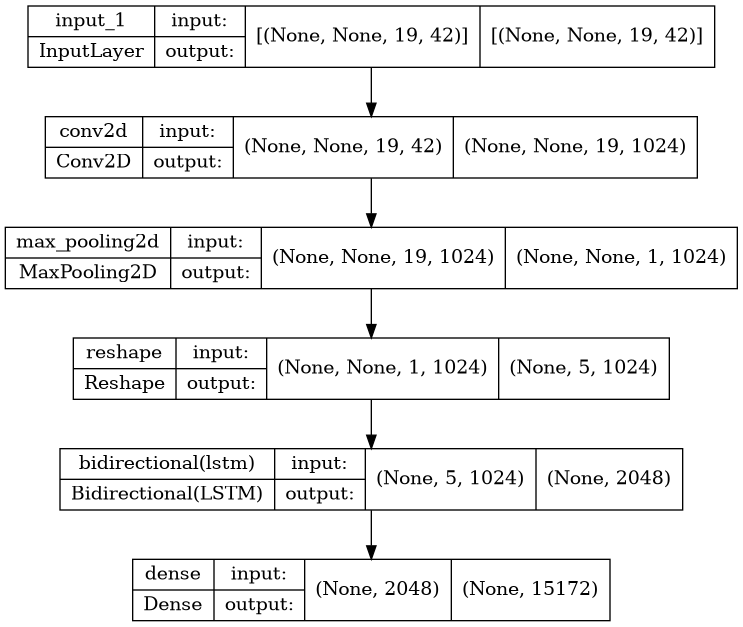

In [53]:
plot_model(model,to_file=pjoin(FOLDER_RESULT,model_name+'.png'), 
                show_layer_names=True, show_shapes=True )

In [54]:
with open( pjoin(FOLDER_RESULT,model_name+'.json'), 'wt') as f: f.write( model.to_json() )

## обучаем модель

In [55]:
learning_rate = 1e-3

optimizer=Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

/opt/python3.8/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [56]:
# преобразовать весь датасет в матрицы OHE займёт очень много памяти
# будем делать это в процессе формирования batch
# построим генератор батчей

# x - номера слов, 
# xc- цепочки номеров слов контекста для x
# batch_size - размер пакета данных
# ccb - матрицы кодов слов (OHE символов в словах, дополненные нулями до единого размера)
# voc_len - количество слов в словаре
def data_gen(x,xc,batch_size,ccb=words_char_code_bin_pad,voc_len=voc_len):
    bc = np.ceil(x.shape[0]/batch_size).astype(int) # количество пакетов данных
    while True:
        # перемешиваем номера примеров
        rand_idx = rng.permutation(range(x.shape[0]))
        # делим список индексов на части
        batches_idx = np.array_split(rand_idx,bc)
        # последовательно формируем и выдаём пакеты данных
        for ii in batches_idx:
            yield  ccb[xc[ii,:]], np.eye(voc_len,dtype=int)[x[ii]]

In [57]:
%%time 

n_epochs = 64
batch_size = 2048

hist = model.fit(
    data_gen(x,x_context,batch_size),
    steps_per_epoch = x.shape[0]//batch_size,
    epochs = n_epochs
)

Epoch 1/64


2022-03-03 12:45:55.744918: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


22/22 [==============================] - 32s 871ms/step - loss: 7.6473 - accuracy: 0.0481
Epoch 2/64
22/22 [==============================] - 18s 831ms/step - loss: 6.8097 - accuracy: 0.1035
Epoch 3/64
22/22 [==============================] - 18s 829ms/step - loss: 6.6941 - accuracy: 0.1038
Epoch 4/64
22/22 [==============================] - 18s 822ms/step - loss: 6.6237 - accuracy: 0.1039
Epoch 5/64
22/22 [==============================] - 19s 850ms/step - loss: 6.5296 - accuracy: 0.1064
Epoch 6/64
22/22 [==============================] - 18s 832ms/step - loss: 6.3423 - accuracy: 0.1156
Epoch 7/64
22/22 [==============================] - 19s 847ms/step - loss: 6.2495 - accuracy: 0.1179
Epoch 8/64
22/22 [==============================] - 18s 838ms/step - loss: 6.0998 - accuracy: 0.1219
Epoch 9/64
22/22 [==============================] - 18s 832ms/step - loss: 5.9378 - accuracy: 0.1234
Epoch 10/64
22/22 [==============================] - 18s 828ms/step - loss: 5.7911 - accuracy: 0.1292


In [58]:
model.save_weights( pjoin(FOLDER_RESULT,model_name+'-%02d.tf'%(n_epochs) ), save_format='tf') 

---

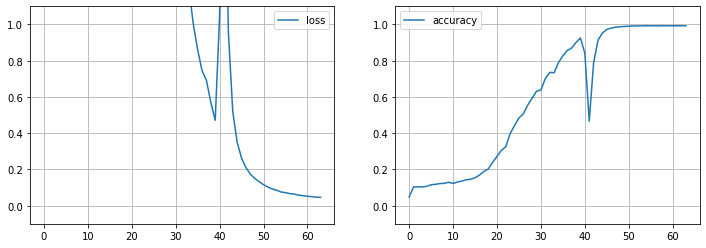

In [59]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])

## тестируем

In [60]:
# !ls result

In [61]:
# from tensorflow.keras.models import model_from_json
# # from tensorflow.keras.models import load_model

# fname='result/charCNN-BiLSTM.json'
# with open( fname, 'rt') as f: model = model_from_json(f.read())
# #model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

# fname = 'result/charCNN-BiLSTM-64.tf'
# model.load_weights( fname )     

In [62]:
def encode_str(s): 
    return np.vstack([
        encode_abc_bin(encode_abc(pad_word(w)))
        for w in tokenize(s) 
    ])[np.newaxis,:]

In [63]:
vocabulary_inv = { vocabulary[k]:k for k in vocabulary } # декодер слов

In [64]:
# начальный контекст
s = data['line'].apply(' '.join).sample().values[0]
s = ' '.join(tokenize(s)[:hist_deep])
s

'но надо , чтоб и'

In [65]:
o = s + ' | ' # результат

for i in range(30):
    t = encode_str(s)
    p = model.predict(t)
    r = np.argmax(p)
    w = vocabulary_inv[r]
    s = ' '.join(tokenize(s)[1:] + [ w ])
    o += ' '+w

o

'но надо , чтоб и |  народ уверовал , что мы знаем , чего хотим , а что те только машут дубиной и бьют по своим . нему вместе . давно , потом можно была никогда'

In [66]:
s

', потом можно была никогда'